In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from datetime import datetime 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [2]:
train = pd.read_csv(r'D:\Загрузки\IDAO 2020\train.csv')
test = pd.read_csv(r'D:\Загрузки\IDAO 2020\Track 1\test.csv')

In [3]:
train.head(3)

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768


In [31]:
test.head(2)

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01T00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01T00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402


In [5]:
train = train.drop('id', axis=1)

In [6]:
len(train.loc[:,'sat_id'].unique())

600

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649912 entries, 0 to 649911
Data columns (total 14 columns):
epoch     649912 non-null object
sat_id    649912 non-null int64
x         649912 non-null float64
y         649912 non-null float64
z         649912 non-null float64
Vx        649912 non-null float64
Vy        649912 non-null float64
Vz        649912 non-null float64
x_sim     649912 non-null float64
y_sim     649912 non-null float64
z_sim     649912 non-null float64
Vx_sim    649912 non-null float64
Vy_sim    649912 non-null float64
Vz_sim    649912 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 69.4+ MB


In [8]:
train.describe()

,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
count,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000,649912.000000
mean,308.730351,-817.243624,423.039342,-75.033412,-0.000571,0.000468,-0.000084,-949.710660,324.557198,-79.766677,-0.000519,0.000394,-0.000312
std,171.482926,25391.507810,25631.511540,20652.050496,2.639041,2.597130,2.116245,25374.076264,25607.472371,20667.988715,2.637491,2.600323,2.113769
min,0.000000,-251938.766780,-291083.016974,-178922.412426,-8.286673,-8.231654,-9.371164,-255037.952966,-282851.387908,-180250.922287,-8.243159,-8.348831,-7.671565
25%,166.000000,-13127.557237,-11620.365836,-8000.289962,-1.892727,-1.874982,-1.255991,-13153.145398,-11736.509125,-7956.446370,-1.896259,-1.877142,-1.246751
50%,312.000000,-506.673520,514.039628,45.175018,0.019951,-0.051700,0.009385,-623.114440,523.437227,56.891526,0.021274,-0.012901,0.012037
75%,461.000000,11318.543144,12614.274408,8279.083423,1.960031,1.845111,1.237103,11190.022140,12547.532119,8235.078108,1.955522,1.862365,1.236030
max,599.000000,200382.689756,212443.393808,197200.530574,8.149559,12.308450,8.644558,200961.158000,209619.553857,198526.091552,7.431851,8.021438,8.644165


In [9]:
train.columns

Index(['epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim', 'y_sim',
       'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'],
      dtype='object')

In [10]:
train_real = train.loc[:, ['epoch','sat_id','x','y','z','Vx','Vy','Vz']]
train_sim = train.loc[:, ['epoch','sat_id','x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']]

In [11]:
print(train_real.columns)
print(train_sim.columns)

Index(['epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz'], dtype='object')
Index(['epoch', 'sat_id', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim',
       'Vz_sim'],
      dtype='object')


## Попробуем посмтроить графики координат для реал и предиктов 

In [12]:
coord_real = train_real[train_real['sat_id'] == 0].loc[:, ['x','y','z']]
coord_sim = train_sim[train_sim['sat_id'] == 0].loc[:, ['x_sim','y_sim','z_sim']]

In [13]:
print('observ number:', train_real[train_real['sat_id'] == 0].shape[0])

observ number: 958


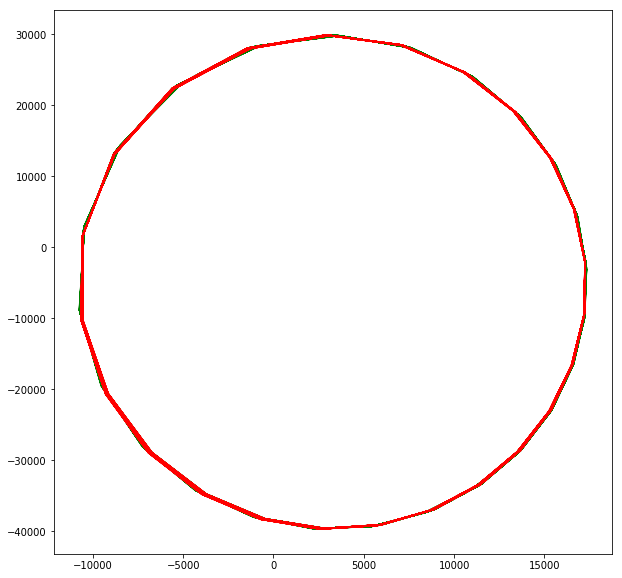

In [14]:
plt.figure(figsize=(10,10))
plt.plot(coord_real.loc[:,'x'], coord_real.loc[:,'y'], 'g')
plt.plot(coord_sim.loc[:,'x_sim'], coord_sim.loc[:,'y_sim'], 'r')

Если присмотреться, то видно, что предикты смещены

In [15]:
diff = pd.DataFrame({'x':np.subtract(coord_real.loc[:,'x'],coord_sim.loc[:,'x_sim']),
                     'y':np.subtract(coord_real.loc[:,'y'],coord_sim.loc[:,'y_sim']),
                     'z':np.subtract(coord_real.loc[:,'z'],coord_sim.loc[:,'z_sim'])})

In [16]:
diff.head(5)

,x,y,z
0,-12.692409,-20.441543,13.262073
1,-12.172318,-29.543301,21.276285
2,-6.825572,-34.527552,32.888826
3,1.368937,-33.237259,44.637815
4,10.266521,-26.790192,53.492019


In [17]:
diff = np.abs(diff)
diff.head()

,x,y,z
0,12.692409,20.441543,13.262073
1,12.172318,29.543301,21.276285
2,6.825572,34.527552,32.888826
3,1.368937,33.237259,44.637815
4,10.266521,26.790192,53.492019


In [18]:
diff.tail()

,x,y,z
953,1911.918388,15612.075013,4879.299912
954,3429.845937,14789.698343,8355.689969
955,5005.320639,13066.730924,11936.165799
956,6572.080659,10195.884818,15459.066758
957,7990.429369,5889.747366,18591.737280


In [19]:
diff.describe()

,x,y,z
count,958.000000,958.000000,958.000000
mean,2195.813550,5436.462537,5065.499649
std,2120.704688,5305.448932,4900.420056
min,0.935108,0.019449,0.144493
25%,71.485954,198.433841,121.724188
50%,1918.363332,5037.648279,4222.863670
75%,3456.898622,7988.854995,8018.753990
max,9158.649797,24606.996844,20854.343912


Если учесть, что значения координат могут варьироваться от -250000 до + 200000, то норм

In [21]:
y_train, y_test, X_train, X_test  = train_test_split(train_real.drop([ 'epoch', 'sat_id'], axis=1), 
                                                    train_sim.drop([ 'epoch', 'sat_id'], axis=1),
                                                    train_size=0.7, test_size=0.3, random_state=1, shuffle=True)

переставлены y, Х, чтобы в у были реальные значения

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(454938, 6)
(454938, 6)
(194974, 6)
(194974, 6)


### Линейная модель 

In [23]:
model_lin = LinearRegression()

model_lin.fit(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1), np.array(y_train.loc[:,'x']))

pred_lin_train =  model_lin.predict(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1))
pred_lin = model_lin.predict(np.array(X_test.loc[:,'x_sim']).reshape(-1, 1))

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_lin_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim']).reshape(-1, 1)))

MAE pred train: 3365.99976533023
MAE pred: 3332.031462084599
MAE sim: 3089.196364769518


In [24]:
model_lin = LinearRegression()

model_lin.fit(np.array(X_train.loc[:,'y_sim']).reshape(-1, 1), np.array(y_train.loc[:,'y']))
pred_lin = model_lin.predict(np.array(X_test.loc[:,'y_sim']).reshape(-1, 1))

print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'y']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'y']), np.array(X_test.loc[:,'y_sim']).reshape(-1, 1)))

MAE pred: 3362.3882974124676
MAE sim: 3133.756272228635


In [25]:
model_lin = LinearRegression()

model_lin.fit(np.array(X_train.loc[:,'z_sim']).reshape(-1, 1), np.array(y_train.loc[:,'z']))
pred_lin = model_lin.predict(np.array(X_test.loc[:,'z_sim']).reshape(-1, 1))

print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'z']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'z']), np.array(X_test.loc[:,'z_sim']).reshape(-1, 1)))

MAE pred: 2530.4598320729183
MAE sim: 2337.4492047405474


In [26]:
model_lin = LinearRegression()

model_lin.fit(np.array(X_train.loc[:,'Vz_sim']).reshape(-1, 1), np.array(y_train.loc[:,'Vz']))
pred_lin = model_lin.predict(np.array(X_test.loc[:,'Vz_sim']).reshape(-1, 1))

print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'Vz']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'Vz']), np.array(X_test.loc[:,'Vz_sim']).reshape(-1, 1)))

MAE pred: 0.5765952991763054
MAE sim: 0.4777916240228887


Вышло хуже симуляции, попробуем по-фану докинуть координаты другие и спиды :))) по осям

In [27]:
model_lin = LinearRegression()

model_lin.fit(X_train.loc[:,['x_sim','Vx_sim']], np.array(y_train.loc[:,'x']))
pred_lin = model_lin.predict(X_test.loc[:,['x_sim','Vx_sim']])

print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim']).reshape(-1, 1)))

MAE pred: 3389.831680769296
MAE sim: 3089.196364769518


In [28]:
model_lin = LinearRegression()

model_lin.fit(X_train.loc[:,['x_sim','y_sim','z_sim']], np.array(y_train.loc[:,'x']))
pred_lin = model_lin.predict(X_test.loc[:,['x_sim','y_sim','z_sim']])

print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim']).reshape(-1, 1)))

MAE pred: 3340.1757499996793
MAE sim: 3089.196364769518


In [29]:
model_lin = LinearRegression()

model_lin.fit(X_train, np.array(y_train.loc[:,'x']))
pred_lin = model_lin.predict(X_test)

print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_lin))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim']).reshape(-1, 1)))

MAE pred: 3401.643147467761
MAE sim: 3089.196364769518


Еще хуже

Соберем сабамит из линейных моделей, чтобы сравнить с sample submission

In [60]:
# train_real = train_real.drop([ 'epoch', 'sat_id'], axis=1) 
# train_sim = train_sim.drop([ 'epoch', 'sat_id'], axis=1)

In [61]:
# model_lin = LinearRegression()

# model_lin.fit(np.array(train_sim.loc[:, 'x_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'x']))
# pred_x = model_lin.predict(np.array(test.loc[:, 'x_sim']).reshape(-1, 1))               

In [62]:
# model_lin.fit(np.array(train_sim.loc[:, 'y_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'y']))
# pred_y = model_lin.predict(np.array(test.loc[:, 'y_sim']).reshape(-1, 1))     

In [63]:
# model_lin.fit(np.array(train_sim.loc[:, 'z_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'z']))
# pred_z = model_lin.predict(np.array(test.loc[:, 'z_sim']).reshape(-1, 1))    

In [64]:
# model_lin.fit(np.array(train_sim.loc[:, 'Vx_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'Vx']))
# pred_Vx = model_lin.predict(np.array(test.loc[:, 'Vx_sim']).reshape(-1, 1))    

In [65]:
# model_lin.fit(np.array(train_sim.loc[:, 'Vy_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'Vy']))
# pred_Vy = model_lin.predict(np.array(test.loc[:, 'Vy_sim']).reshape(-1, 1))     

In [66]:
# model_lin.fit(np.array(train_sim.loc[:, 'Vz_sim']).reshape(-1, 1), np.array(train_real.loc[:, 'Vz']))
# pred_Vz = model_lin.predict(np.array(test.loc[:, 'Vz_sim']).reshape(-1, 1))    

In [67]:
# submission_linear = pd.DataFrame({'id':test.loc[:,'id'], 'x':pred_x, 'y':pred_y, 'z':pred_z, 'Vx':pred_Vx, 'Vy':pred_Vy, 'Vz':pred_Vz})

In [68]:
# submission_linear.to_csv(r'D:\Загрузки\IDAO 2020\Track 1\submission_linear.csv', index=False)

Score :65.1 (baseline: 66.24)

### XGBRegression 

In [73]:
# model = xgb.XGBRegressor(booster='gblinear',
#                  colsample_bytree=0.4,
#                  gamma=0,                 
#                  learning_rate=0.07,
#                  max_depth=3,
#                  n_estimators=10000,                                                                    
#                  reg_alpha=0.75,
#                  reg_lambda=0.45,
#                  seed=1)

In [79]:
model = xgb.XGBRegressor(booster='gblinear')

model.fit(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1), np.array(y_train.loc[:,'x']))

pred_xgb = model.predict(np.array(X_test.loc[:,'x_sim']).reshape(-1, 1))
pred_xgb_train = model.predict(np.array(X_train.loc[:,'x_sim']).reshape(-1, 1))

print('MAE pred train:', mean_absolute_error(np.array(y_train.loc[:,'x']), pred_xgb_train))
print('MAE pred:', mean_absolute_error(np.array(y_test.loc[:,'x']), pred_xgb))
print('MAE sim:', mean_absolute_error(np.array(y_test.loc[:,'x']), np.array(X_test.loc[:,'x_sim']).reshape(-1, 1)))

[18:10:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE pred train: 3366.2250638530472
MAE pred: 3332.2582908570134
MAE sim: 3089.196364769518


Почти то же самое, что и LinearRegression

## Исправление ошибки SGP4 

In [73]:
train = pd.read_csv(r'D:\Загрузки\IDAO 2020\train.csv')
test = pd.read_csv(r'D:\Загрузки\IDAO 2020\Track 1\test.csv')

train_real = train.loc[:, ['id', 'epoch','sat_id','x','y','z','Vx','Vy','Vz']]
train_sim = train.loc[:, ['id', 'epoch','sat_id','x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']]

#### Перевод эпохи во время-дату 

In [28]:
train_real.loc[0:2,'epoch']

0    2014-01-01T00:00:00.000
1    2014-01-01T00:46:43.000
2    2014-01-01T01:33:26.001
Name: epoch, dtype: object

In [18]:
print(train_real.loc[0,'epoch'])
print(type(train_real.loc[0,'epoch']))

2014-01-01T00:00:00.000
<class 'str'>


In [34]:
print('Date:', datetime.strptime(train_real.loc[0,'epoch'].split('T')[0], '%Y-%m-%d'))

Date: 2014-01-01 00:00:00


In [36]:
print('Time:', datetime.strptime(train_real.loc[0,'epoch'].split('T')[1], '%H:%M:%S.%f'))

Time: 1900-01-01 00:00:00


In [38]:
print('Date Time:', datetime.strptime(train_real.loc[0,'epoch'], '%Y-%m-%dT%H:%M:%S.%f'))

Date Time: 2014-01-01 00:00:00


In [45]:
datetime.strptime(train_real.loc[0,'epoch'], '%Y-%m-%dT%H:%M:%S.%f').microsecond


0

След ячейка долго выполняется, потому что я написал херню, вероятно

In [63]:
pd.DataFrame(train_real.loc[:,'epoch']).apply(lambda x: [datetime.strptime(train_real.loc[0,'epoch'], '%Y-%m-%dT%H:%M:%S.%f').year,
                                           datetime.strptime(train_real.loc[0,'epoch'], '%Y-%m-%dT%H:%M:%S.%f').month,
                                           datetime.strptime(train_real.loc[0,'epoch'], '%Y-%m-%dT%H:%M:%S.%f').day,
                                           datetime.strptime(train_real.loc[0,'epoch'], '%Y-%m-%dT%H:%M:%S.%f').hour,
                                           datetime.strptime(train_real.loc[0,'epoch'], '%Y-%m-%dT%H:%M:%S.%f').minute,
                                           datetime.strptime(train_real.loc[0,'epoch'], '%Y-%m-%dT%H:%M:%S.%f').second,
                                           datetime.strptime(train_real.loc[0,'epoch'], '%Y-%m-%dT%H:%M:%S.%f').microsecond],
                               axis=1, result_type='expand')

,0,1,2,3,4,5,6
0,2014,1,1,0,0,0,0
1,2014,1,1,0,0,0,0
2,2014,1,1,0,0,0,0
3,2014,1,1,0,0,0,0
4,2014,1,1,0,0,0,0
...,...,...,...,...,...,...,...
649907,2014,1,1,0,0,0,0
649908,2014,1,1,0,0,0,0
649909,2014,1,1,0,0,0,0
649910,2014,1,1,0,0,0,0


In [90]:
pd.to_timedelta(train_real.loc[:,['epoch']], format='%Y-%m-%dT%H:%M:%S.%f')

TypeError: to_timedelta() got an unexpected keyword argument 'format'

In [111]:
train_real.head(3)

,epoch,sat_id,x,y,z,Vx,Vy,Vz,path
0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,26080.000000
1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,26686.896582
2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,28338.043990


#### Перевод координат в точки 

In [91]:
#train_real
#train_sim

Пока посчитаем пройденный путь без учета сферичности Земли (по прямой)

In [74]:
train_real['path'] = np.sqrt(np.power(train_real.loc[:, 'x'],2) + 
                             np.power(train_real.loc[:, 'y'],2) + 
                             np.power(train_real.loc[:, 'z'],2)) 

In [75]:
train_sim['path'] = np.sqrt(np.power(train_sim.loc[:, 'x_sim'],2) + 
                            np.power(train_sim.loc[:, 'y_sim'],2) + 
                            np.power(train_sim.loc[:, 'z_sim'],2)) 

Посмотрим увеличивается ли дельта между реальными и симул. данными

In [79]:
def plot_coord_dif(n):
    coord_dif = train_real[train_real['sat_id'] == n].loc[:, 'path'] - train_sim[train_sim['sat_id'] == n].loc[:, 'path']
    coord_range = train_real[train_real['sat_id'] == n].shape[0]
    plt.plot(list(range(0, coord_range)), np.array(coord_dif))

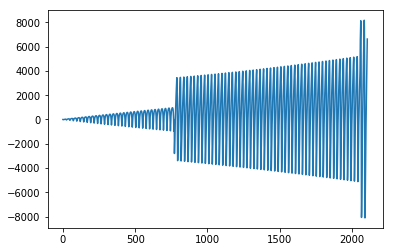

In [80]:
plot_coord_dif(1)

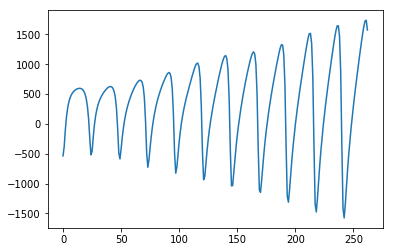

In [89]:
plot_coord_dif(222)

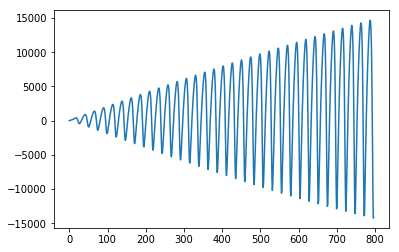

In [90]:
plot_coord_dif(333)

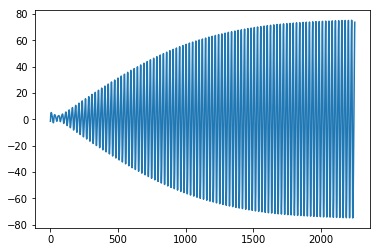

In [91]:
plot_coord_dif(444)

#### Стабильна ли скорость во времени 

In [113]:
train_real['V'] = np.sqrt(np.power(train_real.loc[:, 'Vx'],2) + 
                              np.power(train_real.loc[:, 'Vy'],2) + 
                              np.power(train_real.loc[:, 'Vz'],2)) 

In [115]:
train_sim['V'] = np.sqrt(np.power(train_sim.loc[:, 'Vx_sim'],2) + 
                              np.power(train_sim.loc[:, 'Vy_sim'],2) + 
                              np.power(train_sim.loc[:, 'Vz_sim'],2)) 

In [119]:
train_real.loc[:, ['epoch','sat_id','V']].head(10)

,epoch,sat_id,V
0,2014-01-01T00:00:00.000,0,4.406588
1,2014-01-01T00:46:43.000,0,4.326931
2,2014-01-01T01:33:26.001,0,4.120966
3,2014-01-01T02:20:09.001,0,3.854871
4,2014-01-01T03:06:52.002,0,3.582143
5,2014-01-01T03:53:35.002,0,3.331210
6,2014-01-01T04:40:18.003,0,3.113272
7,2014-01-01T05:27:01.003,0,2.931178
8,2014-01-01T06:13:44.004,0,2.784557
9,2014-01-01T07:00:27.004,0,2.672147


In [117]:
train_sim.loc[:, ['epoch','sat_id','V']].head(10)

,epoch,sat_id,V
0,2014-01-01T00:00:00.000,0,4.404340
1,2014-01-01T00:46:43.000,0,4.324766
2,2014-01-01T01:33:26.001,0,4.119305
3,2014-01-01T02:20:09.001,0,3.853846
4,2014-01-01T03:06:52.002,0,3.581697
5,2014-01-01T03:53:35.002,0,3.331236
6,2014-01-01T04:40:18.003,0,3.113676
7,2014-01-01T05:27:01.003,0,2.931893
8,2014-01-01T06:13:44.004,0,2.785534
9,2014-01-01T07:00:27.004,0,2.673353


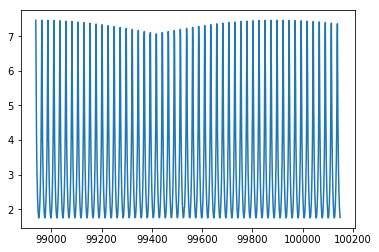

In [138]:
plt.plot(list(train_real[train_real['sat_id'] == 99].index), list(train_real[train_real['sat_id'] == 99].loc[:,'V']))